<a href="https://colab.research.google.com/github/DeekshithaGona/NLP/blob/main/Tweet_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


---


##  Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [37]:
!pip install nlp

In [38]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


##  Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [39]:
!pip install datasets

In [40]:
from datasets import load_dataset
dataset=load_dataset("dair-ai/emotion")

# text: a string feature.
# label: a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

In [41]:
dataset


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [42]:
train=dataset['train']
val=dataset['validation']
test=dataset['test']

In [43]:
def get_tweet(data):
  tweets=[x['text'] for x in data]
  labels=[x['label']for x in data]
  return tweets,labels


In [44]:
tweets,labels=get_tweet(train)
tweets[1],labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

##  Tokenizer

1. Tokenizing the tweets

In [45]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [46]:
tokenizer=Tokenizer(num_words=10000,oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [47]:
print(tokenizer.texts_to_sequences([tweets[0]]))
tweets[0]

[[2, 139, 3, 679]]


'i didnt feel humiliated'

##  Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

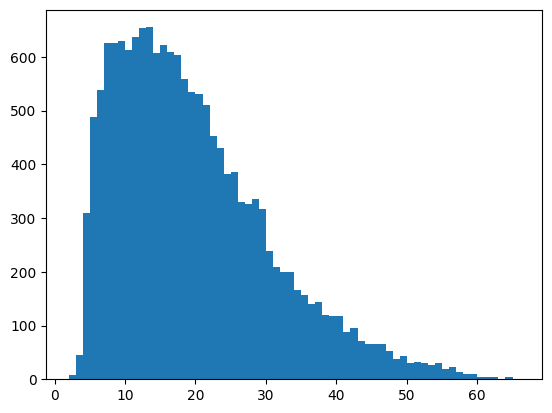

In [48]:
lengths=[len(i.split(' ')) for i in tweets]
plt.hist(lengths,bins=len(set(lengths)))
plt.show()

In [49]:
maxlen=50

from tensorflow.keras.preprocessing.sequence import pad_sequences


In [50]:
def get_sequences(tokenizer,tweets):
  sequences=tokenizer.texts_to_sequences(tweets)
  padded=pad_sequences(sequences,truncating='post',padding='post',maxlen=maxlen)
  return padded



In [51]:
padded_train_seq=get_sequences(tokenizer,tweets)

In [52]:
print(padded_train_seq[1001])
print(tweets[1001])

[   2 1776  214    5    6  763 1614  223    4 7958  123   14   17  363
    5 1202  129   15 7959    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
i drove us to the car parts place and terry feels like im safe to drive again so yippee


##  Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [53]:
classes=set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


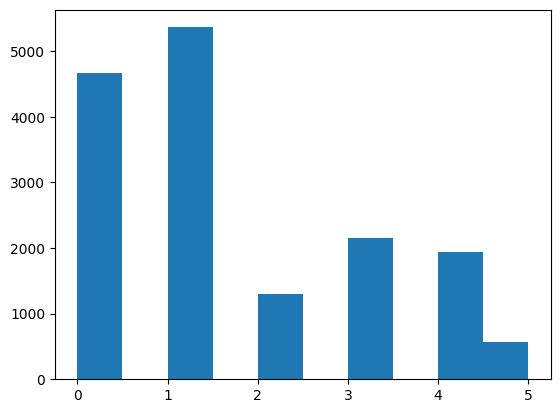

In [54]:
plt.hist(labels,bins=10)
plt.show()
# class imbalance

In [55]:

import numpy as np


names_to_ids = lambda labels: np.array([x for x in labels])
train_labels = names_to_ids(labels)
print(train_labels[0])


0


# # text: a string feature.
# label: a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

## Creating the Model

1. Creating the model
2. Compiling the model

In [56]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_length=maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6,activation='softmax')
]
)
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [57]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


##  Training the Model

1. Preparing a validation set
2. Training the model

In [58]:
val_tweets,val_labels=get_tweet(val)
val_seq=get_sequences(tokenizer,val_tweets)
#val_labels=names_to_ids(val_lables)

In [59]:
val_tweets[0],val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [60]:
import numpy as np

val_seq = np.array(val_seq)
val_labels = np.array(val_labels)


train_labels = np.array(train_labels)


h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)]
)


Epoch 1/20
500/500 [==============================] - 48s 73ms/step - loss: 1.3246 - accuracy: 0.4689 - val_loss: 0.8649 - val_accuracy: 0.6820
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.5728 - accuracy: 0.8012 - val_loss: 0.5742 - val_accuracy: 0.8010
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.3335 - accuracy: 0.8882 - val_loss: 0.5152 - val_accuracy: 0.8200
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2331 - accuracy: 0.9243 - val_loss: 0.4452 - val_accuracy: 0.8650
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.1635 - accuracy: 0.9502 - val_loss: 0.4432 - val_accuracy: 0.8650
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1286 - accuracy: 0.9616 - val_loss: 0.5262 - val_accuracy: 0.8665
Epoch 7/20
500/500 [==============================] - 10s 19ms/step - loss: 0.1118 - accuracy: 0.9649 - val_loss: 0.4241 - val_accuracy: 0.8

##  Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

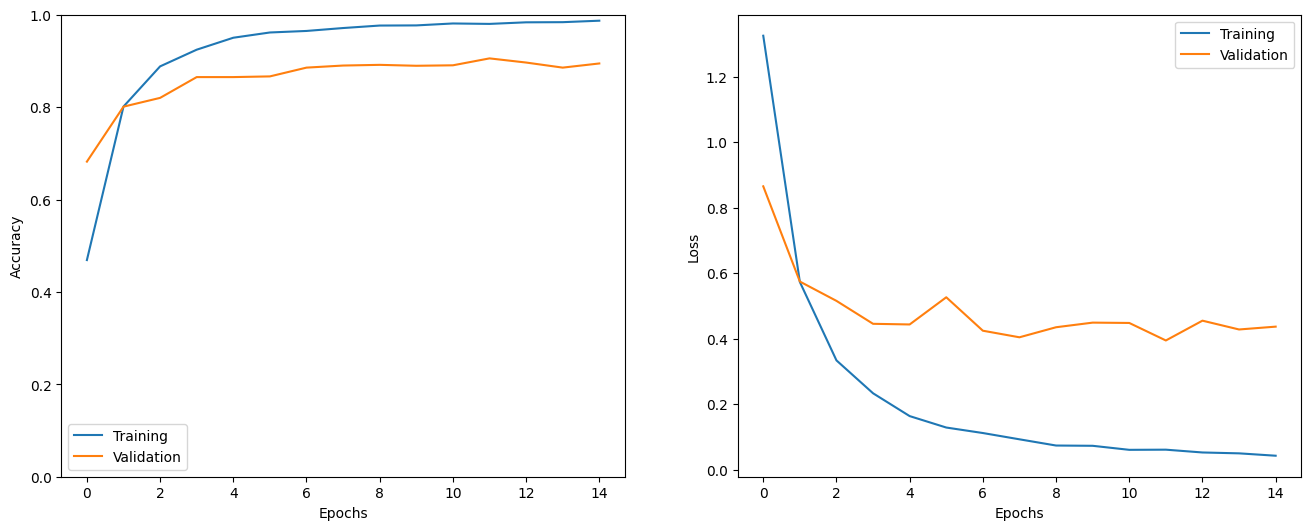

In [61]:
show_history(h)

In [62]:
test_tweets,test_labels=get_tweet(test)
test_seq=get_sequences(tokenizer,test_tweets)
test_labels=names_to_ids(test_labels)

In [63]:
_=model.evaluate(test_seq,test_labels)

63/63 [==============================] - 0s 6ms/step - loss: 0.4542 - accuracy: 0.8910


In [64]:
i = random.randint(0, len(test_labels)-1)
print('Sentence: ',test_tweets[i])
print('Emotion: ',test_labels[i])
p=model.predict(np.expand_dims(test_seq[i],axis=0))[0]
names_to_ids = lambda labels: np.array([x for x in test_labels])
train_labels = names_to_ids(labels)
pred_class=train_labels[np.argmax(p).astype('uint8')]
print('Predicted Emotion:',pred_class)

Sentence:  im feeling scared and the rage filled im mad at me
Emotion:  4
1/1 [==============================] - 1s 1s/step
Predicted Emotion: 0


In [65]:
emotion_labels = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}

# prediction result 'pred_class' as an integer (0 to 5)
pred_emotion = emotion_labels[pred_class]

print('Predicted Emotion:', pred_emotion)


Predicted Emotion: sadness
